In [1]:
import os
import random
import torch
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
from torchvision.io import read_image
import torch.nn as nn



from functools import partial

import matplotlib.pyplot as plt
from glob import glob
from tqdm import tqdm  # Import tqdm for progress bars

from mae_models import MaskedAutoencoderViT 

/home/alcindo/.pyenv/versions/meu_ambiente/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:

# Set device to GPU if available, else CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


print("Using device: ", device)

Using device:  cuda


In [3]:
BATCH_SIZE = 128

In [4]:
# Custom dataset for grayscale images (1 channel)
class ImageDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        # Get list of image file paths (adjust extension if needed)
        self.image_paths = glob(os.path.join(root_dir, "*.png"))
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        # Read the image using torchvision.io.read_image and normalize to [0, 1]
        image = read_image(img_path).float() / 255.0  # Image in 1 channel (grayscale)
        if self.transform:
            image = self.transform(image)
        return image

In [5]:

# Define the image transformations (resize to 224x224)
transform = transforms.Compose([
    transforms.Resize((224, 224), antialias=True)
])

# Define paths for data directories
data_dir = "/home/alcindo/projeto/masked-autoencoders-cows/data"
train_dir = os.path.join(data_dir, "train")
val_dir = os.path.join(data_dir, "validation")

# Create dataset instances
train_dataset = ImageDataset(root_dir=train_dir, transform=transform)
val_dataset = ImageDataset(root_dir=val_dir, transform=transform)

# Create DataLoaders with multi-processing and pinned memory for efficiency
train_loader = DataLoader(train_dataset, batch_size= BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size= BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)


In [6]:
# (self, img_size=224, patch_size=16, in_chans=3,
#                  embed_dim=1024, depth=24, num_heads=16,
#                  decoder_embed_dim=512, decoder_depth=8, decoder_num_heads=16,
#                  mlp_ratio=4., norm_layer=nn.LayerNorm, norm_pix_loss=False)


# Initialize the MAE model with in_channels=1 for grayscale images and send it to device
model = MaskedAutoencoderViT(
        patch_size=16, embed_dim=64, depth=6, num_heads=8, in_chans=1, img_size= (224,224),
        decoder_embed_dim=32, decoder_depth=4, decoder_num_heads=4,
        mlp_ratio=4, norm_layer=partial(nn.LayerNorm, eps=1e-6))


model = model.to(device)
# Define the optimizer (AdamW)
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)


In [7]:

# split the images located in the batch into patches images[128, 1, 224, 224]-> (128, 1, num_patches, patch_size, patch_size)

def split_images(images, patch_size):
    # Get the image size
    H, W = images.shape[-2:]
    # Calculate the n6umber of patches in height and width
    num_patches_h = H // patch_size
    num_patches_w = W // patch_size
    # Split the images into patches
    patches = images.unfold(2, patch_size, patch_size).unfold(3, patch_size, patch_size)
    patches = patches.contiguous().view(images.size(0), images.size(1), num_patches_h*num_patches_w, patch_size, patch_size)
    return patches

def apply_mask_to_patches(images, patches, masks, patch_size):
    """
    Substitui os patches mascarados por uma matriz de 1s.

    images: tensor original [B, C, H, W]
    patches: tensor de patches [B, C, num_patches, patch_size, patch_size]
    masks: tensor de máscara [B, num_patches] (0 para manter, 1 para mascarar)
    patch_size: tamanho dos patches
    """
    B, C, num_patches, H, W = patches.shape  # [128, 1, 196, 16, 16]

    # Criar tensor de 1s do mesmo tamanho de patches
    masked_patches = patches.clone()
    ones_patch = torch.ones((C, patch_size, patch_size), device=patches.device)

    # Aplicar máscara manualmente usando loops
    for b in range(masks.shape[0]):  # Para cada imagem no batch
        for i in range(masks.shape[1]):  # Para cada patch
            if masks[b, i] == 1:
                masked_patches[b, :, i, :, :] = ones_patch  # Substituir por 1s

    # Reconstruir as imagens mascaradas
    num_patches_per_row = int(images.shape[-1] // patch_size)  # Ex: 224 / 16 = 14 patches por linha
    masked_images = masked_patches.view(B, C, num_patches_per_row, num_patches_per_row, patch_size, patch_size)
    masked_images = masked_images.permute(0, 1, 2, 4, 3, 5).contiguous().view(B, C, images.shape[-2], images.shape[-1])

    return masked_images

def visualize_image(original, masked_image, recon_images):
    """
    Plota imagens originais e mascaradas.
    """

    index = random.randint(0, original.shape[0]-1)

    fig, axes = plt.subplots(1, 3,figsize=(10, 5 ))


    axes[0].imshow(original[index,0].cpu().detach().numpy(), cmap="gray")
    axes[0].set_title("original")
    axes[0].axis("off")

        # imagem mascarada
    axes[1].imshow(masked_image[index,0].cpu().detach().numpy(), cmap="gray")
    axes[1].set_title("masked")
    axes[1].axis("off")

        # Imagem reconstruída
    axes[2].imshow(recon_images[index,0].cpu().detach().numpy(), cmap="gray")
    axes[2].set_title("reconstructed")
    axes[2].axis("off")

    plt.show()

Epoch [1/100] Train Loss: 0.06722837


Epoch [1/100] Validation Loss: 0.03400586


Epoch [2/100] Train Loss: 0.02101411


Epoch [2/100] Validation Loss: 0.01252064


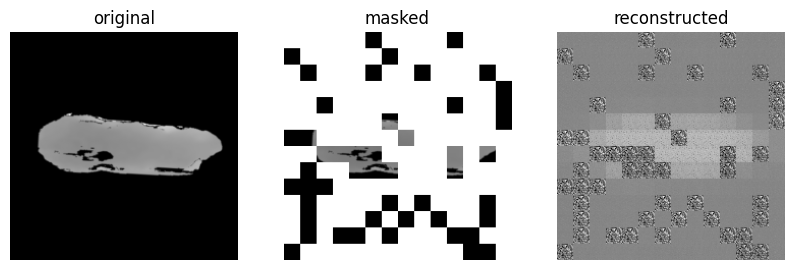

Epoch [3/100] Train Loss: 0.01120602


Epoch [3/100] Validation Loss: 0.01072415


Epoch [4/100] Train Loss: 0.01014908


Epoch [4/100] Validation Loss: 0.00991610


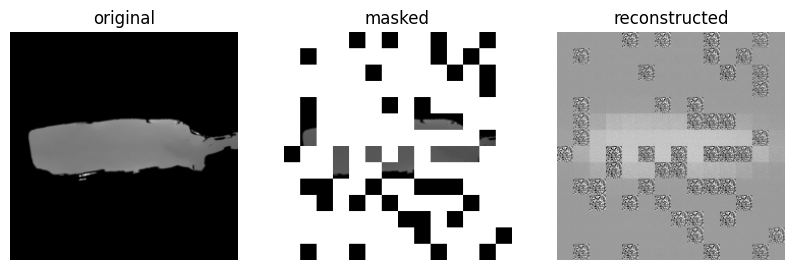

Epoch [5/100] Train Loss: 0.00930108


Epoch [5/100] Validation Loss: 0.00885684


Epoch [6/100] Train Loss: 0.00839738


Epoch [6/100] Validation Loss: 0.00803670


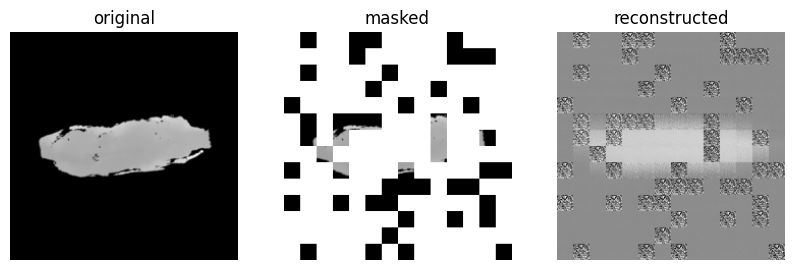

Epoch [7/100] Train Loss: 0.00779936


Epoch [7/100] Validation Loss: 0.00757616


Epoch [8/100] Train Loss: 0.00750074


Epoch [8/100] Validation Loss: 0.00739619


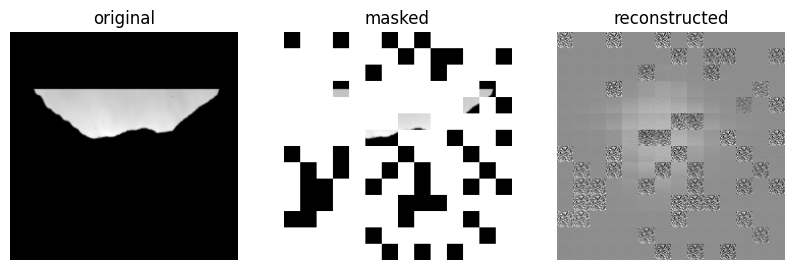

Epoch [9/100] Train Loss: 0.00735246


Epoch [9/100] Validation Loss: 0.00723967


Epoch [10/100] Train Loss: 0.00710871


Epoch [10/100] Validation Loss: 0.00682281


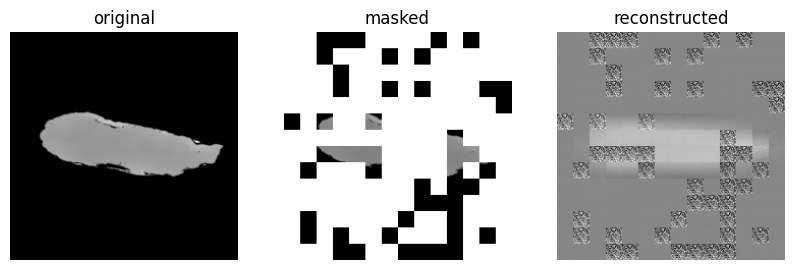

Epoch [11/100] Train Loss: 0.00651738


Epoch [11/100] Validation Loss: 0.00628520


Epoch [12/100] Train Loss: 0.00611955


Epoch [12/100] Validation Loss: 0.00595968


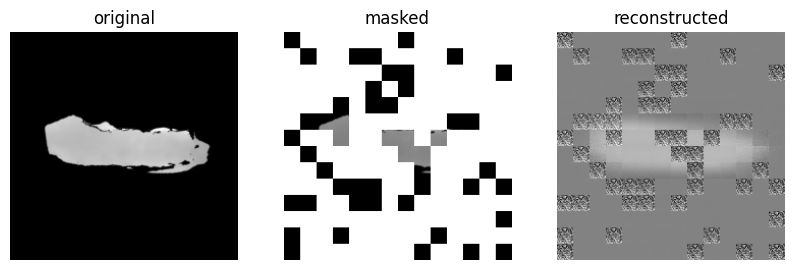

Epoch [13/100] Train Loss: 0.00587866


Epoch [13/100] Validation Loss: 0.00575743


Epoch [14/100] Train Loss: 0.00569156


Epoch [14/100] Validation Loss: 0.00575175


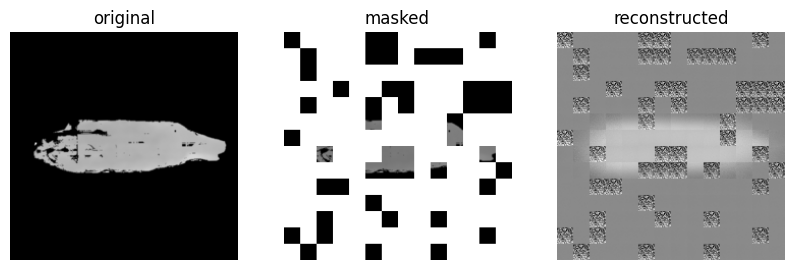

Epoch [15/100] Train Loss: 0.00557473


Epoch [15/100] Validation Loss: 0.00548767


Epoch [16/100] Train Loss: 0.00544881


Epoch [16/100] Validation Loss: 0.00575113


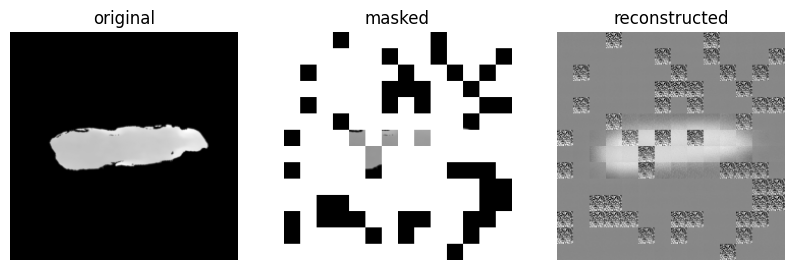

Epoch [17/100] Train Loss: 0.00535561


Epoch [17/100] Validation Loss: 0.00536973


Epoch [18/100] Train Loss: 0.00523082


Epoch [18/100] Validation Loss: 0.00523381


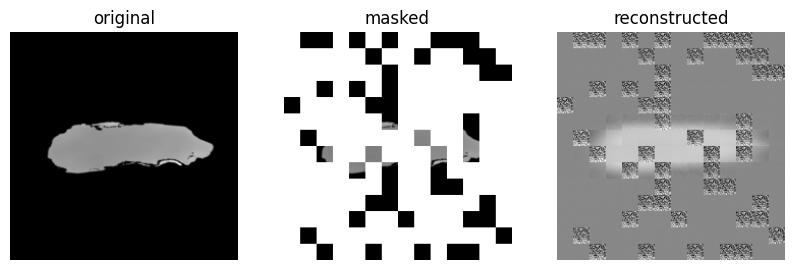

Epoch [19/100] Train Loss: 0.00517846


Epoch [19/100] Validation Loss: 0.00507585


Epoch [20/100] Train Loss: 0.00509235


Epoch [20/100] Validation Loss: 0.00505667


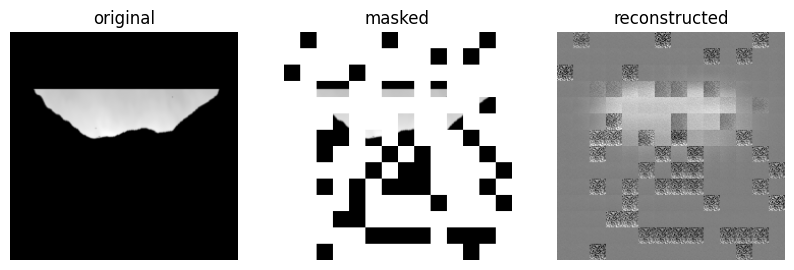

Epoch [21/100] Train Loss: 0.00504357


Epoch [21/100] Validation Loss: 0.00501895


Epoch [22/100] Train Loss: 0.00500331


Epoch [22/100] Validation Loss: 0.00498337


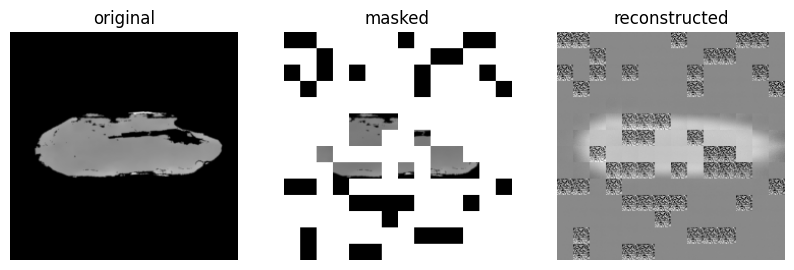

Epoch [23/100] Train Loss: 0.00494678


Epoch [23/100] Validation Loss: 0.00492993


Epoch [24/100] Train Loss: 0.00489600


Epoch [24/100] Validation Loss: 0.00492768


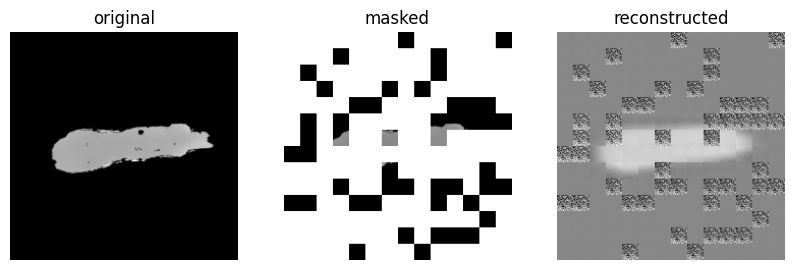

Epoch [25/100] Train Loss: 0.00484639


Epoch [25/100] Validation Loss: 0.00481729


Epoch [26/100] Train Loss: 0.00478079


Epoch [26/100] Validation Loss: 0.00473109


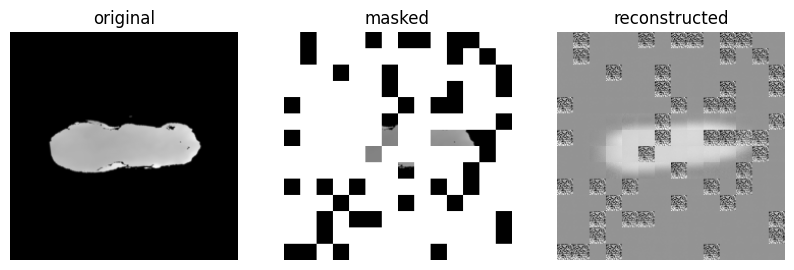

Epoch [27/100] Train Loss: 0.00472589


Epoch [27/100] Validation Loss: 0.00473254


Epoch [28/100] Train Loss: 0.00467851


Epoch [28/100] Validation Loss: 0.00464335


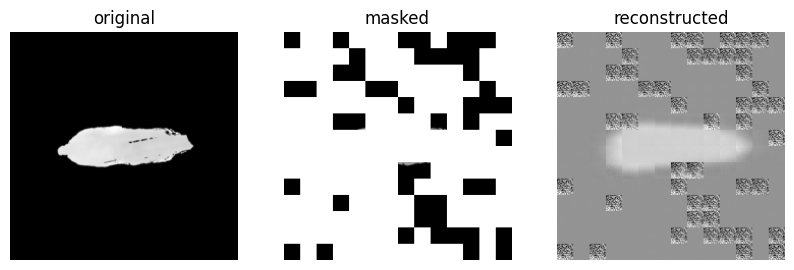

Epoch [29/100] Train Loss: 0.00462493


Epoch [29/100] Validation Loss: 0.00461720


Epoch [30/100] Train Loss: 0.00458581


Epoch [30/100] Validation Loss: 0.00454076


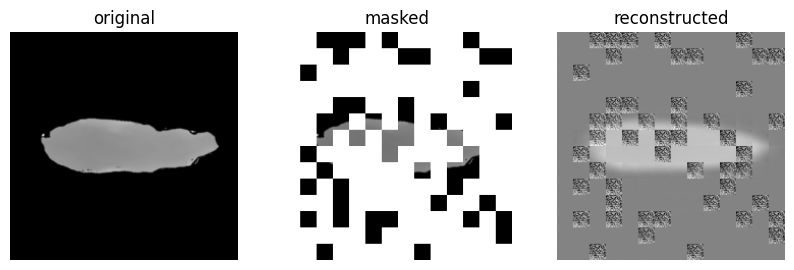

Epoch [31/100] Train Loss: 0.00453501


Epoch [31/100] Validation Loss: 0.00453142


Epoch [32/100] Train Loss: 0.00450015


Epoch [32/100] Validation Loss: 0.00450438


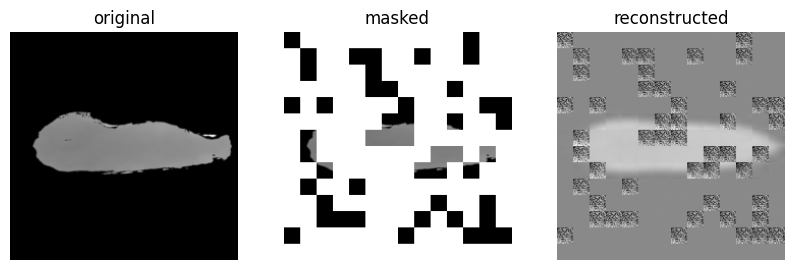

Epoch [33/100] Train Loss: 0.00447792


Epoch [33/100] Validation Loss: 0.00456905


Epoch [34/100] Train Loss: 0.00444232


Epoch [34/100] Validation Loss: 0.00444267


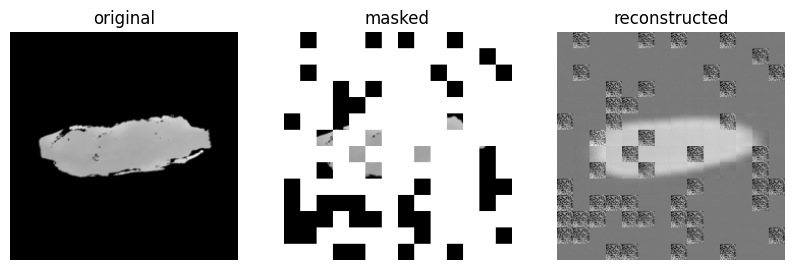

Epoch [35/100] Train Loss: 0.00442289


Epoch [35/100] Validation Loss: 0.00460565


Epoch [36/100] Train Loss: 0.00437946


Epoch [36/100] Validation Loss: 0.00436547


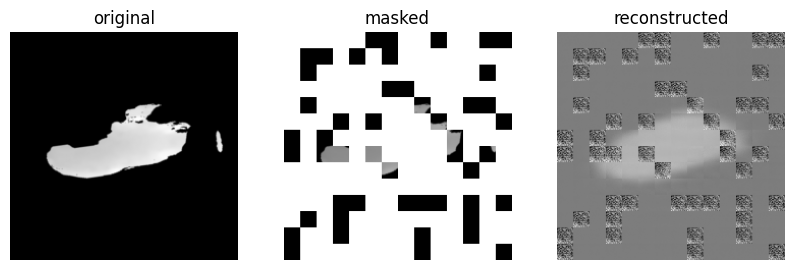

Epoch [37/100] Train Loss: 0.00438377


Epoch [37/100] Validation Loss: 0.00452251


Epoch [38/100] Train Loss: 0.00435640


Epoch [38/100] Validation Loss: 0.00438619


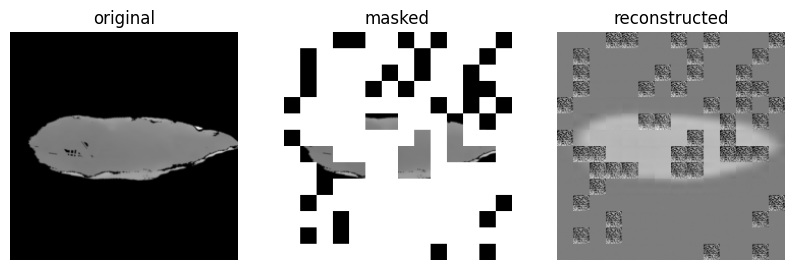

Epoch [39/100] Train Loss: 0.00433882


Epoch [39/100] Validation Loss: 0.00432187


Epoch [40/100] Train Loss: 0.00431210


Epoch [40/100] Validation Loss: 0.00429812


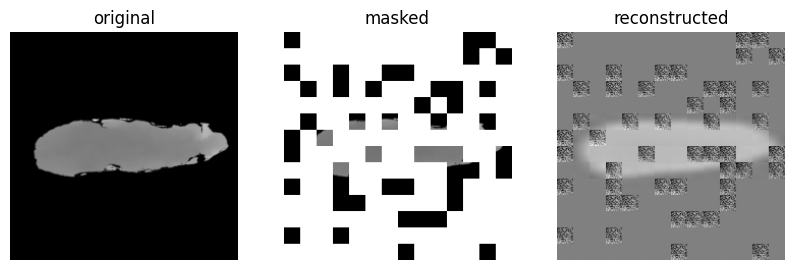

Epoch [41/100] Train Loss: 0.00428901


Epoch [41/100] Validation Loss: 0.00426404


Epoch [42/100] Train Loss: 0.00427731


Epoch [42/100] Validation Loss: 0.00428688


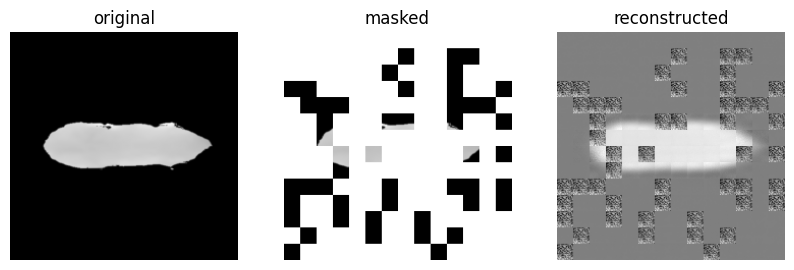

Epoch [43/100] Train Loss: 0.00425767


Epoch [43/100] Validation Loss: 0.00426067


Epoch [44/100] Train Loss: 0.00422824


Epoch [44/100] Validation Loss: 0.00425187


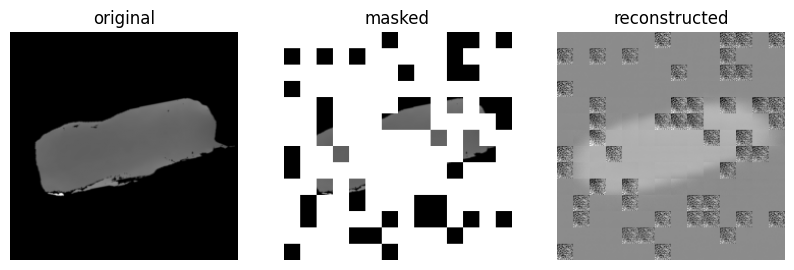

Epoch [45/100] Train Loss: 0.00422469


Epoch [45/100] Validation Loss: 0.00422916


Epoch [46/100] Train Loss: 0.00420701


Epoch [46/100] Validation Loss: 0.00428908


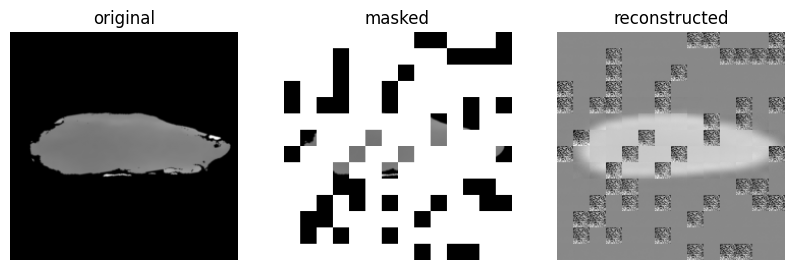

Epoch [47/100] Train Loss: 0.00419563


Epoch [47/100] Validation Loss: 0.00419317


Epoch [48/100] Train Loss: 0.00418724


Epoch [48/100] Validation Loss: 0.00423445


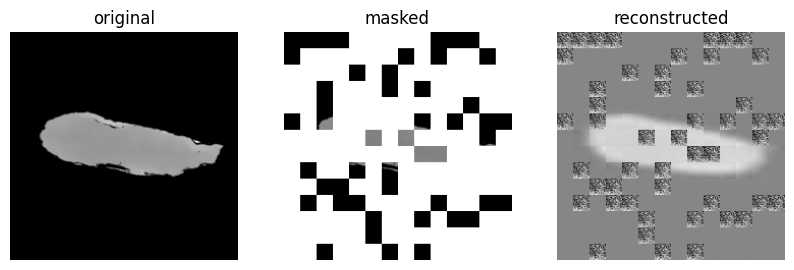

Epoch [49/100] Train Loss: 0.00417653


Epoch [49/100] Validation Loss: 0.00415817


Epoch [50/100] Train Loss: 0.00415580


Epoch [50/100] Validation Loss: 0.00411928


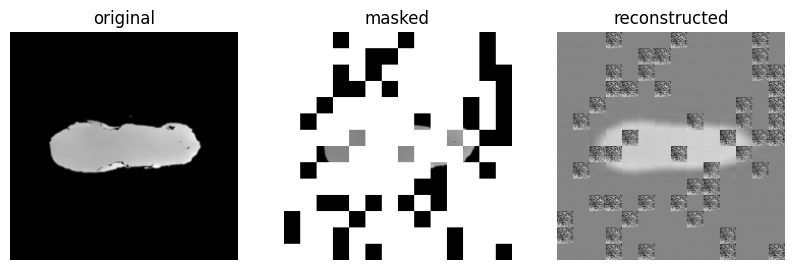

Epoch [51/100] Train Loss: 0.00415287


Epoch [51/100] Validation Loss: 0.00416816


Epoch [52/100] Train Loss: 0.00412418


Epoch [52/100] Validation Loss: 0.00409430


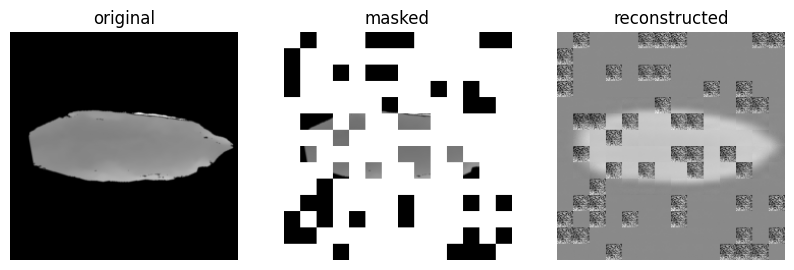

Epoch [53/100] Train Loss: 0.00411957


Epoch [53/100] Validation Loss: 0.00410042


Epoch [54/100] Train Loss: 0.00410055


Epoch [54/100] Validation Loss: 0.00408368


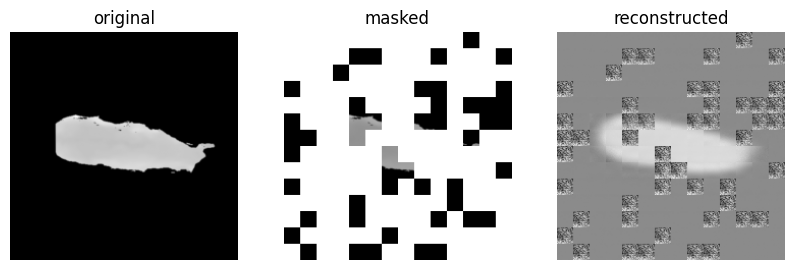

Epoch [55/100] Train Loss: 0.00409617


Epoch [55/100] Validation Loss: 0.00410281


Epoch [56/100] Train Loss: 0.00407456


Epoch [56/100] Validation Loss: 0.00409310


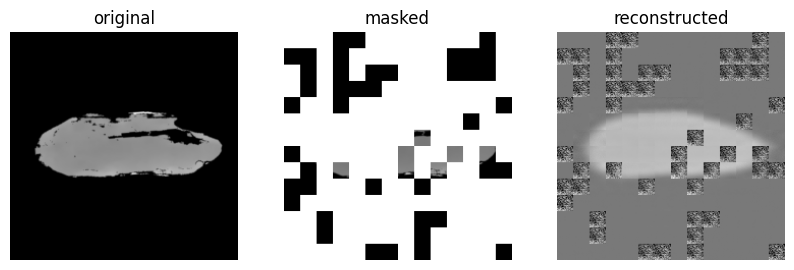

Epoch [57/100] Train Loss: 0.00406549


Epoch [57/100] Validation Loss: 0.00403634


Epoch [58/100] Train Loss: 0.00406430


Epoch [58/100] Validation Loss: 0.00405559


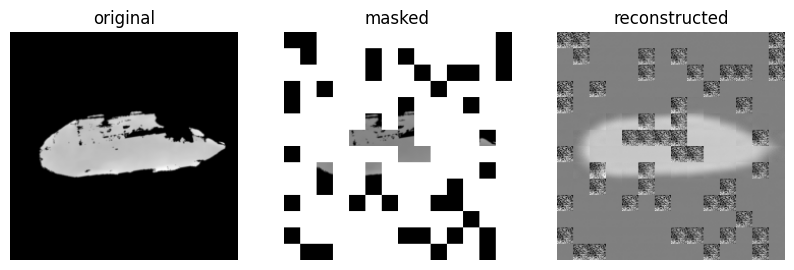

Epoch [59/100] Train Loss: 0.00405839


Epoch [59/100] Validation Loss: 0.00405162


Epoch [60/100] Train Loss: 0.00404199


Epoch [60/100] Validation Loss: 0.00404281


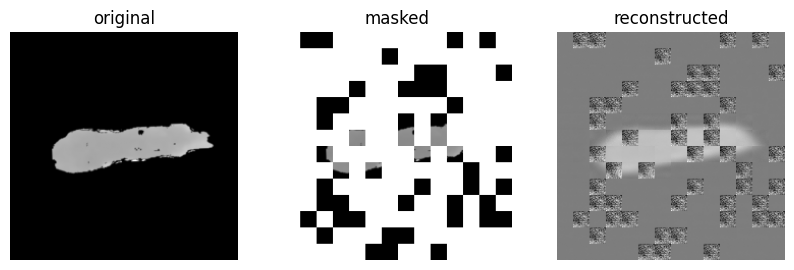

Epoch [61/100] Train Loss: 0.00403028


Epoch [61/100] Validation Loss: 0.00406571


Epoch [62/100] Train Loss: 0.00402679


Epoch [62/100] Validation Loss: 0.00413001


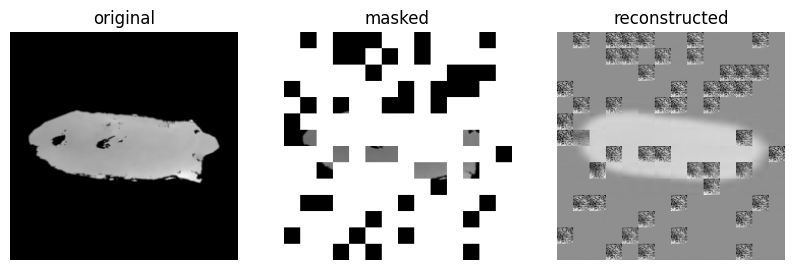

Epoch [63/100] Train Loss: 0.00401519


Epoch [63/100] Validation Loss: 0.00401832


Epoch [64/100] Train Loss: 0.00399718


Epoch [64/100] Validation Loss: 0.00413028


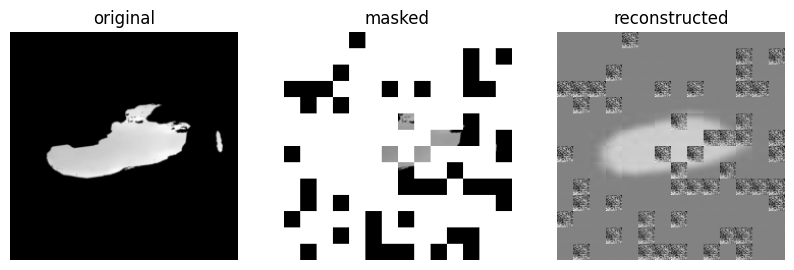

Epoch [65/100] Train Loss: 0.00398831


Epoch [65/100] Validation Loss: 0.00394093


Epoch [66/100] Train Loss: 0.00398409


Epoch [66/100] Validation Loss: 0.00398353


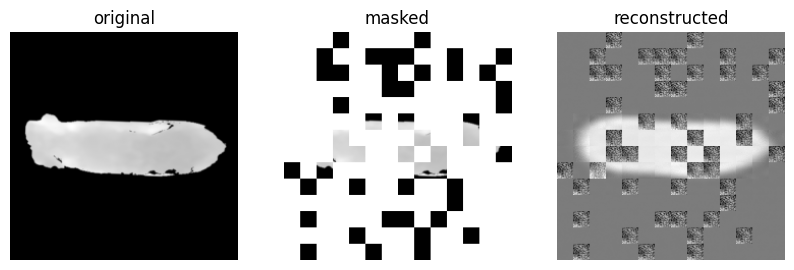

Epoch [67/100] Train Loss: 0.00397487


Epoch [67/100] Validation Loss: 0.00395261


Epoch [68/100] Train Loss: 0.00397285


Epoch [68/100] Validation Loss: 0.00401570


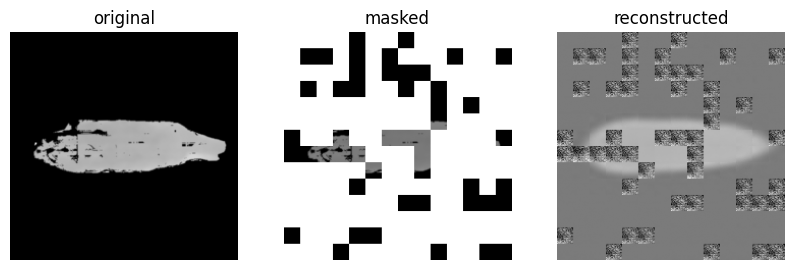

Epoch [69/100] Train Loss: 0.00396486


Epoch [69/100] Validation Loss: 0.00398379


Epoch [70/100] Train Loss: 0.00396067


Epoch [70/100] Validation Loss: 0.00397398


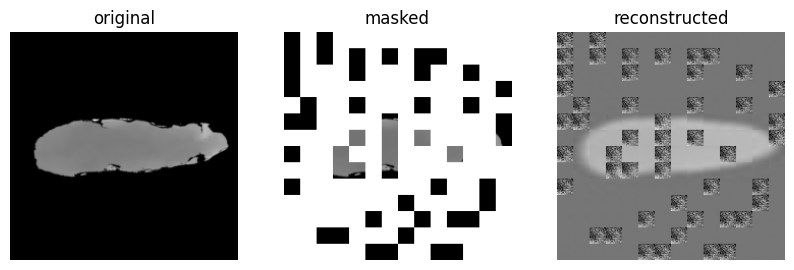

Epoch [71/100] Train Loss: 0.00394749


Epoch [71/100] Validation Loss: 0.00395717


Epoch [72/100] Train Loss: 0.00393613


Epoch [72/100] Validation Loss: 0.00396808


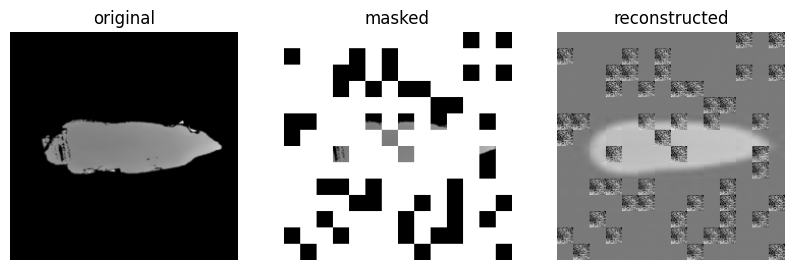

Epoch [73/100] Train Loss: 0.00393194


Epoch [73/100] Validation Loss: 0.00397711


Epoch [74/100] Train Loss: 0.00392597


Epoch [74/100] Validation Loss: 0.00392961


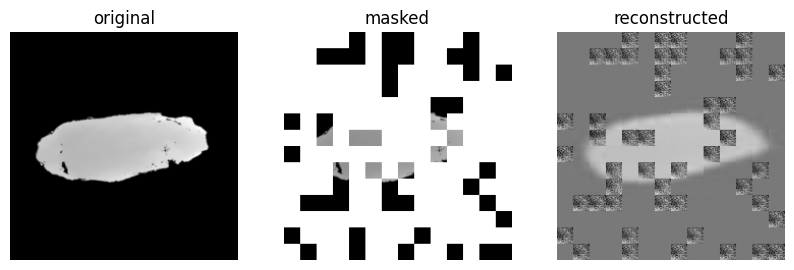

Epoch [75/100] Train Loss: 0.00391401


Epoch [75/100] Validation Loss: 0.00392679


Epoch [76/100] Train Loss: 0.00391717


Epoch [76/100] Validation Loss: 0.00389688


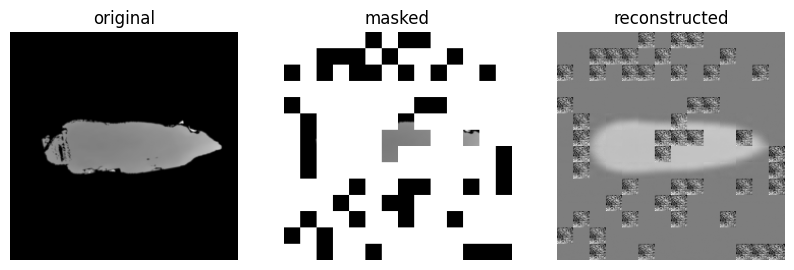

Epoch [77/100] Train Loss: 0.00390376


Epoch [77/100] Validation Loss: 0.00393448


Epoch [78/100] Train Loss: 0.00390302


Epoch [78/100] Validation Loss: 0.00392847


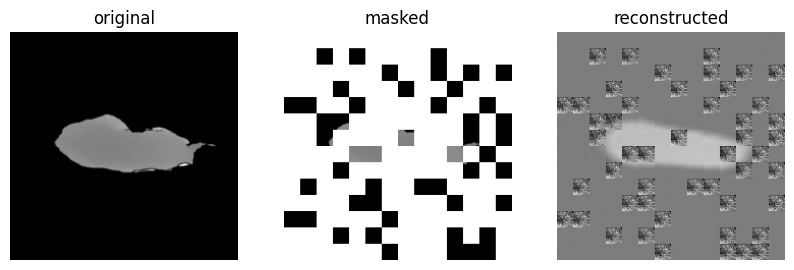

Epoch [79/100] Train Loss: 0.00389432


Epoch [79/100] Validation Loss: 0.00393399


Epoch [80/100] Train Loss: 0.00386446


Epoch [80/100] Validation Loss: 0.00396095


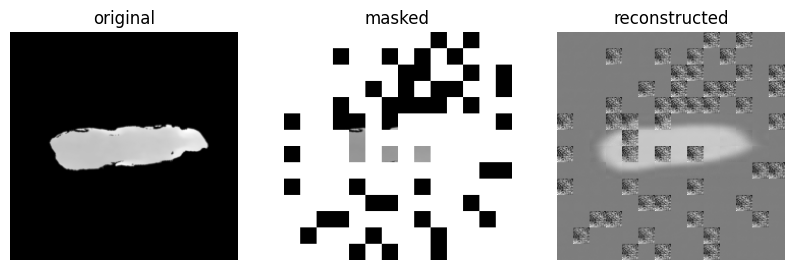

Epoch [81/100] Train Loss: 0.00387148


Epoch [81/100] Validation Loss: 0.00394707


Epoch [82/100] Train Loss: 0.00387073


Epoch [82/100] Validation Loss: 0.00394442


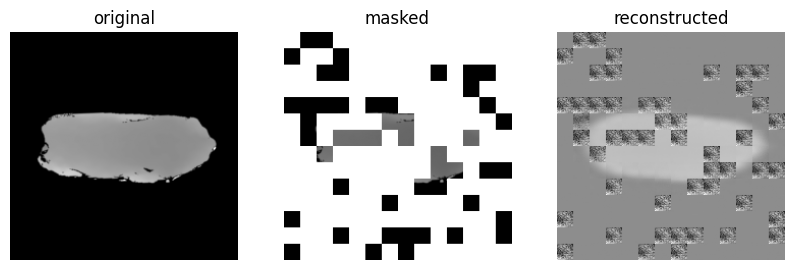

Epoch [83/100] Train Loss: 0.00386307


Epoch [83/100] Validation Loss: 0.00382192


Epoch [84/100] Train Loss: 0.00384916


Epoch [84/100] Validation Loss: 0.00384022


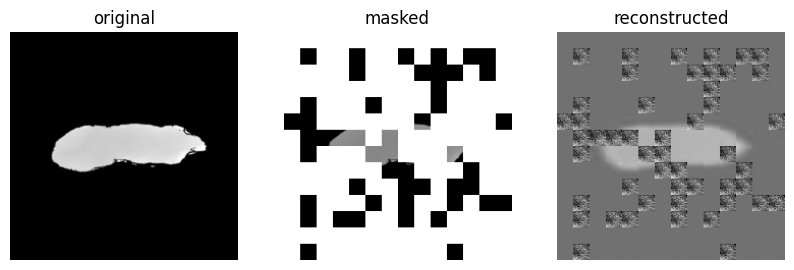

Epoch [85/100] Train Loss: 0.00383755


Epoch [85/100] Validation Loss: 0.00385685


Epoch [86/100] Train Loss: 0.00384411


Epoch [86/100] Validation Loss: 0.00382931


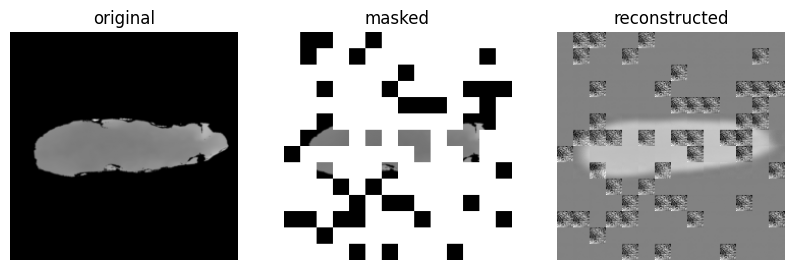

Epoch [87/100] Train Loss: 0.00383593


Epoch [87/100] Validation Loss: 0.00384594


Epoch [88/100] Train Loss: 0.00382177


Epoch [88/100] Validation Loss: 0.00389010


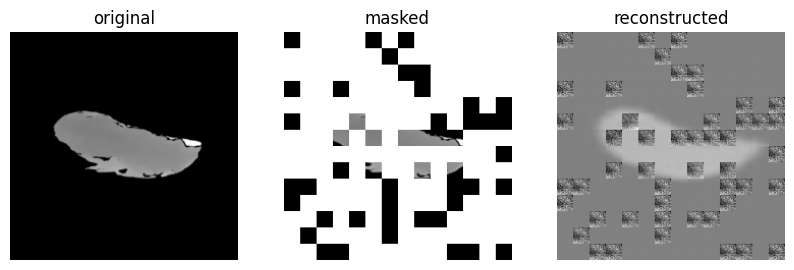

Epoch [89/100] Train Loss: 0.00382640


Epoch [89/100] Validation Loss: 0.00382888


Epoch [90/100] Train Loss: 0.00381875


Epoch [90/100] Validation Loss: 0.00382219


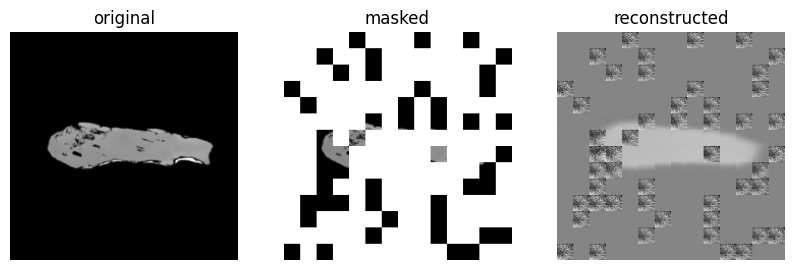

Epoch [91/100] Train Loss: 0.00381298


Epoch [91/100] Validation Loss: 0.00385196


Epoch [92/100] Train Loss: 0.00380763


Epoch [92/100] Validation Loss: 0.00381080


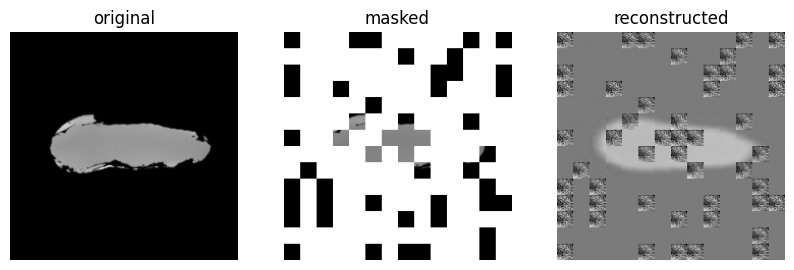

Epoch [93/100] Train Loss: 0.00380979


Epoch [93/100] Validation Loss: 0.00383177


Epoch [94/100] Train Loss: 0.00378970


Epoch [94/100] Validation Loss: 0.00379254


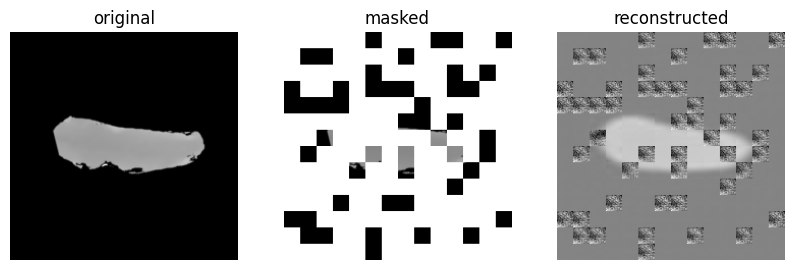

Epoch [95/100] Train Loss: 0.00379713


Epoch [95/100] Validation Loss: 0.00384744


Epoch [96/100] Train Loss: 0.00377902


Epoch [96/100] Validation Loss: 0.00374966


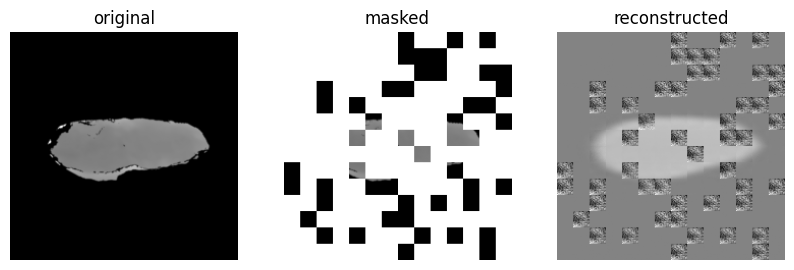

Epoch [97/100] Train Loss: 0.00378620


Epoch [97/100] Validation Loss: 0.00379458


Epoch [98/100] Train Loss: 0.00378219


Epoch [98/100] Validation Loss: 0.00376756


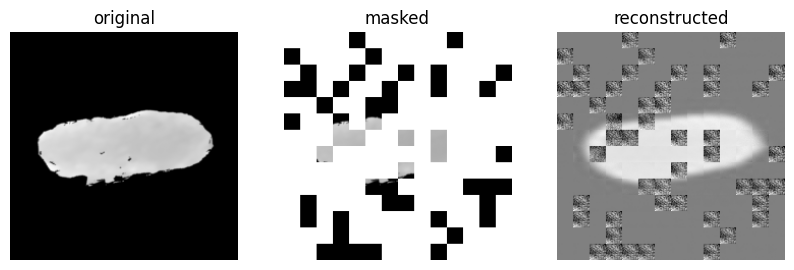

Epoch [99/100] Train Loss: 0.00377137


Epoch [99/100] Validation Loss: 0.00377439


Epoch [100/100] Train Loss: 0.00376072


Epoch [100/100] Validation Loss: 0.00375928


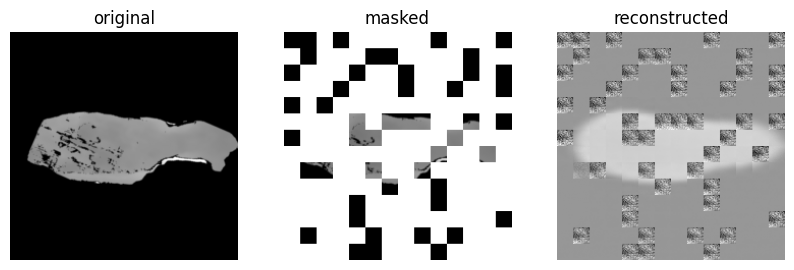

Training complete!


In [8]:

# Training loop
num_epochs = 100


for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    
    # Training loop with progress bar
    train_loop = tqdm(train_loader, desc=f"Epoch [{epoch+1}/{num_epochs}] - Train", leave=False)
    for images in train_loop:
        images = images.to(device)  # Move images to GPU
        
        optimizer.zero_grad()
        loss, _, _ = model(images)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        train_loop.set_postfix(loss=loss.item())
    
    avg_loss = total_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}] Train Loss: {avg_loss:.8f}")
    
    # Validation loop with progress bar
    model.eval()
    val_loss = 0.0
    val_loop = tqdm(val_loader, desc=f"Epoch [{epoch+1}/{num_epochs}] - Val", leave=False)
    with torch.no_grad():
        for images in val_loop:
            images = images.to(device)
            loss, _, _ = model(images)
            val_loss += loss.item()
            val_loop.set_postfix(loss=loss.item())
            
    avg_val_loss = val_loss / len(val_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}] Validation Loss: {avg_val_loss:.8f}")
    
    # plot each 5 epoch

    if (epoch+1) % 2 == 0:
        model.eval()
        with torch.no_grad():
            # select random batch
            images = next(iter(val_loader))
            images = images.to(device)

            _, pred, masks = model(images)

            # Split the images into patches
            patches = split_images(images, patch_size=16)

            masked_images = apply_mask_to_patches(images, patches, masks, patch_size=16)
            
            # unpatch the pred
            recon_images = model.unpatchify(pred)

            visualize_image(images, masked_images, recon_images)
            

        
print("Training complete!")

In [9]:
#save model

torch.save(model.state_dict(), "./checkpoints/mae_checkpoint.pth")

In [10]:
# load model

# checkpoint = torch.load("./checkpoints/mae_checkpoint.pth")
# model.load_state_dict(checkpoint)

In [11]:

# select a batch from validation set

images = next(iter(val_loader)).to(device)

model.eval()

with torch.no_grad():
    _, recon_images, masks = model(images)


# Split the images into patches
patches = split_images(images, patch_size=16)

In [12]:
recon_images_unpatch = model.unpatchify(recon_images)

In [13]:
# Aplicar máscara às imagens
masked_images = apply_mask_to_patches(images, patches, masks, patch_size = 16)


# Visualizar
visualize_images(images, masked_images,recon_images_unpatch)

NameError: name 'visualize_images' is not defined